In [ ]:
# @title 1. Install Dependencies
!pip install -q autodistill autodistill-grounded-sam supervision roboflow nvidia-ml-py psutil

# Grounding DINO + SAM2

Loading Grounding DINO + SAM...
trying to load grounding dino directly
final text_encoder_type: bert-base-uncased
Processing /content/image_1.jpg...

========== HARDWARE PERFORMANCE REPORT ==========
⏱️  Time Taken:       3.9749 seconds
💻 Avg CPU Usage:    76.8% (Max: 100.0%)
🧠 RAM Usage:        3.65 GB (Peak)
🎮 GPU Model:        Tesla T4
⚡ Avg GPU Util:     84.5% (Max: 99.0%)
💾 VRAM Usage:       10.34 GB (Peak)

Generating image...


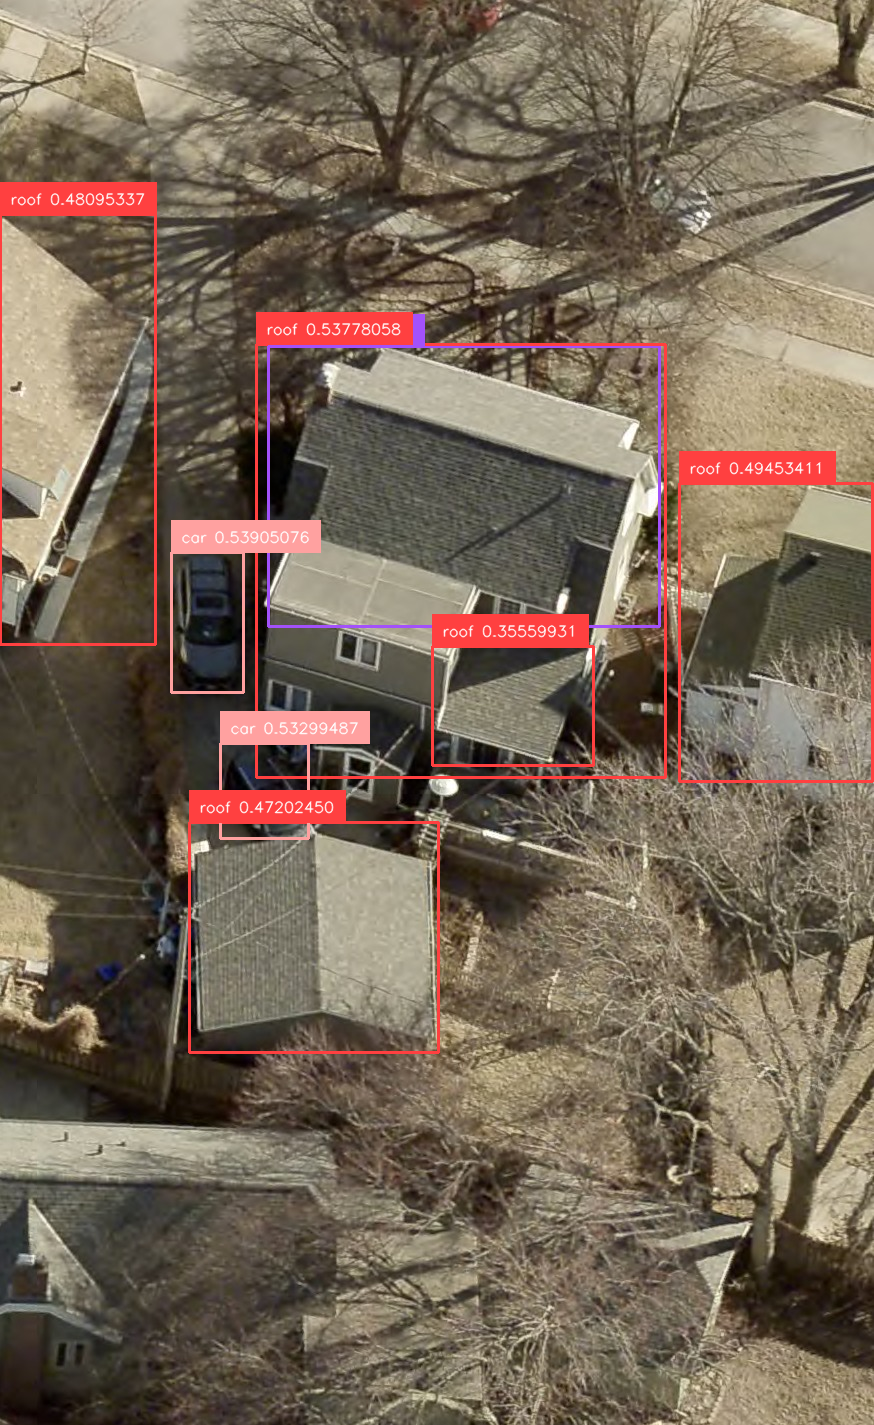

True

In [ ]:
# @title 2. Auto-Annotate with Hardware Stats (Fixed)
import cv2
import time
import threading
import psutil
import pynvml
import numpy as np
import supervision as sv
from autodistill_grounded_sam import GroundedSAM
from autodistill.detection import CaptionOntology
from google.colab.patches import cv2_imshow

# --- CONFIGURATION ---
IMAGE_PATH = "/content/image_1.jpg"
ONTOLOGY = CaptionOntology({
    "shingled roof": "roof",
    "house rooftop": "roof",
    "car": "car"
})
# ---------------------

class HardwareMonitor:
    def __init__(self):
        self.running = False
        self.stats = {
            'cpu_usage': [],
            'ram_used_gb': [],
            'gpu_util': [],
            'gpu_mem_gb': []
        }
        self.has_gpu = False
        self.gpu_name = "Unknown GPU"

        # Initialize GPU Monitor with stricter checks
        try:
            pynvml.nvmlInit()
            self.handle = pynvml.nvmlDeviceGetHandleByIndex(0)
            name = pynvml.nvmlDeviceGetName(self.handle)
            # Handle bytes vs string decoding safely
            if isinstance(name, bytes):
                self.gpu_name = name.decode('utf-8')
            else:
                self.gpu_name = name

            # Only set this to True if everything above succeeded
            self.has_gpu = True
        except Exception as e:
            self.has_gpu = False # Force False on any error
            print(f"Hardware Monitor: GPU not active or accessible ({e}). Using CPU stats only.")

    def _monitor_loop(self):
        while self.running:
            try:
                # CPU & RAM
                self.stats['cpu_usage'].append(psutil.cpu_percent(interval=None))
                self.stats['ram_used_gb'].append(psutil.virtual_memory().used / (1024**3))

                # GPU
                if self.has_gpu:
                    util = pynvml.nvmlDeviceGetUtilizationRates(self.handle)
                    mem = pynvml.nvmlDeviceGetMemoryInfo(self.handle)
                    self.stats['gpu_util'].append(util.gpu)
                    self.stats['gpu_mem_gb'].append(mem.used / (1024**3))
            except:
                pass # Ignore monitoring glitches
            time.sleep(0.1)

    def start(self):
        self.running = True
        self.thread = threading.Thread(target=self._monitor_loop)
        self.thread.start()

    def stop(self):
        self.running = False
        if hasattr(self, 'thread'):
            self.thread.join()

    def report(self, duration):
        print(f"\n{'='*10} HARDWARE PERFORMANCE REPORT {'='*10}")
        print(f"⏱️  Time Taken:       {duration:.4f} seconds")

        # CPU
        if self.stats['cpu_usage']:
            avg_cpu = np.mean(self.stats['cpu_usage'])
            max_cpu = np.max(self.stats['cpu_usage'])
            print(f"💻 Avg CPU Usage:    {avg_cpu:.1f}% (Max: {max_cpu:.1f}%)")
            print(f"🧠 RAM Usage:        {np.max(self.stats['ram_used_gb']):.2f} GB (Peak)")

        # GPU
        if self.has_gpu and self.stats['gpu_util']:
            avg_gpu = np.mean(self.stats['gpu_util'])
            max_gpu = np.max(self.stats['gpu_util'])
            max_vram = np.max(self.stats['gpu_mem_gb'])
            print(f"🎮 GPU Model:        {self.gpu_name}")
            print(f"⚡ Avg GPU Util:     {avg_gpu:.1f}% (Max: {max_gpu:.1f}%)")
            print(f"💾 VRAM Usage:       {max_vram:.2f} GB (Peak)")
        print("="*48 + "\n")

# --- MAIN EXECUTION ---

print("Loading Grounding DINO + SAM...")
base_model = GroundedSAM(ontology=ONTOLOGY)

monitor = HardwareMonitor()

print(f"Processing {IMAGE_PATH}...")
start_time = time.time()
monitor.start()

try:
    predictions = base_model.predict(IMAGE_PATH)
finally:
    monitor.stop()
    end_time = time.time()

monitor.report(end_time - start_time)

# Visualization
print("Generating image...")
image = cv2.imread(IMAGE_PATH)
labels = [
    f"{base_model.ontology.classes()[class_id]} {confidence:0.8f}"
    for class_id, confidence
    in zip(predictions.class_id, predictions.confidence)
]

box_annotator = sv.BoxAnnotator()
annotated_image = box_annotator.annotate(scene=image.copy(), detections=predictions)

label_annotator = sv.LabelAnnotator()
annotated_image = label_annotator.annotate(scene=annotated_image, detections=predictions, labels=labels)

cv2_imshow(annotated_image)
cv2.imwrite("performance_annotated.jpg", annotated_image)

# Moondream V2 Testing

In [ ]:
!pip install pillow torchao

In [ ]:
# @title Run Moondream (Stable Float16 Version)
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from PIL import Image

# 1. Load the Standard Model (Not the 4-bit specific repo)
# We use torch.float16 which fits easily on T4 GPU (approx 5GB VRAM usage)
model_id = "vikhyatk/moondream2"

print(f"Loading {model_id} in float16...")
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    torch_dtype=torch.float16, # <--- The fix: Use standard FP16
    device_map={"": "cuda"}
)

# 2. Load Image
image_path = "/content/image_1.jpg"
image = Image.open(image_path)

# 3. Run Inference

# Captioning
print("\n--- Short Caption ---")
print(model.caption(image, length="short")["caption"])

print("\n--- Normal Caption ---")
print(model.caption(image, length="normal")["caption"])

# Visual Querying
print("\n--- Visual Query ---")
question = "How many people are in the image?"
# Note: Newer moondream versions often prefer 'query' or 'answer_question'
try:
    answer = model.query(image, question)["answer"]
except:
    # Fallback if API changed in the base model
    encoded_image = model.encode_image(image)
    answer = model.answer_question(encoded_image, question, tokenizer=None)
print(f"Q: {question}\nA: {answer}")

# Object Detection
print("\n--- Object Detection ---")
try:
    # Detect 'face' (or 'car', 'person' etc)
    target = "face"
    detection_result = model.detect(image, target)
    objects = detection_result["objects"]
    print(f"Found {len(objects)} {target}(s)")

    # Print first few matches
    for i, obj in enumerate(objects[:3]):
        print(f" {i+1}. {obj}")
except Exception as e:
    print(f"Detection not supported by this specific model revision: {e}")

# Pointing
print("\n--- Pointing ---")
try:
    target = "person"
    pointing_result = model.point(image, target)
    points = pointing_result["points"]
    print(f"Found {len(points)} point(s) for '{target}'")
except Exception as e:
    print(f"Pointing not supported by this specific model revision: {e}")

Loading vikhyatk/moondream2 in float16...


config.json:   0%|          | 0.00/277 [00:00<?, ?B/s]

hf_moondream.py: 0.00B [00:00, ?B/s]

moondream.py: 0.00B [00:00, ?B/s]

config.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/vikhyatk/moondream2:
- config.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


image_crops.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/vikhyatk/moondream2:
- image_crops.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


lora.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/vikhyatk/moondream2:
- lora.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vision.py: 0.00B [00:00, ?B/s]

layers.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/vikhyatk/moondream2:
- layers.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/vikhyatk/moondream2:
- vision.py
- layers.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


utils.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/vikhyatk/moondream2:
- utils.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


region.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/vikhyatk/moondream2:
- region.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


text.py: 0.00B [00:00, ?B/s]

rope.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/vikhyatk/moondream2:
- rope.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/vikhyatk/moondream2:
- text.py
- rope.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/vikhyatk/moondream2:
- moondream.py
- config.py
- image_crops.py
- lora.py
- vision.py
- utils.py
- region.py
- text.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/vikhyatk/moondream2:
- hf_moondream.py

model.safetensors:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]


--- Short Caption ---
A two-story gray house with a gray roof, white garage door, and white picket fence is situated in a suburban neighborhood, with a car parked in the driveway and a bare tree nearby.

--- Normal Caption ---
A gray house with a dark gray or black roof stands as the central focus in a residential area. The house is situated in a residential neighborhood with mostly bare trees, suggesting it might be winter or early spring. Two cars are parked in the driveway, which also has a portion of a garage or carport. A chain-link fence separates the house from a paved area that appears to be a driveway or street. Other houses in the area share a similar architectural style with some gray roofs. The neighborhood also features bare trees, a paved street, and utility poles and wires.

--- Visual Query ---
Q: How many people are in the image?
A: There are no people in the image.

--- Object Detection ---
Found 0 face(s)

--- Pointing ---
Found 0 point(s) for 'person'


In [ ]:
# @title Run Moondream (Stable Float16 Version)
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from PIL import Image

# 1. Load the Standard Model (Not the 4-bit specific repo)
# We use torch.float16 which fits easily on T4 GPU (approx 5GB VRAM usage)
model_id = "vikhyatk/moondream2"

print(f"Loading {model_id} in float16...")
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    torch_dtype=torch.float16, # <--- The fix: Use standard FP16
    device_map={"": "cuda"}
)

# 2. Load Image
image_path = "/content/image_1.jpg"
image = Image.open(image_path)

# 3. Run Inference

# # Captioning
# print("\n--- Short Caption ---")
# print(model.caption(image, length="short")["caption"])

# print("\n--- Normal Caption ---")
# print(model.caption(image, length="normal")["caption"])

# # Visual Querying
# print("\n--- Visual Query ---")
# question = "How many people are in the image?"
# # Note: Newer moondream versions often prefer 'query' or 'answer_question'
# try:
#     answer = model.query(image, question)["answer"]
# except:
#     # Fallback if API changed in the base model
#     encoded_image = model.encode_image(image)
#     answer = model.answer_question(encoded_image, question, tokenizer=None)
# print(f"Q: {question}\nA: {answer}")

# Object Detection
print("\n--- Object Detection ---")
try:
    # Detect 'face' (or 'car', 'person' etc)
    target = "rooftop"
    detection_result = model.detect(image, target)
    objects = detection_result["objects"]
    print(f"Found {len(objects)} {target}(s)")

    # Print first few matches
    for i, obj in enumerate(objects[:3]):
        print(f" {i+1}. {obj}")
except Exception as e:
    print(f"Detection not supported by this specific model revision: {e}")

# Pointing
# print("\n--- Pointing ---")
# try:
#     target = "person"
#     pointing_result = model.point(image, target)
#     points = pointing_result["points"]
#     print(f"Found {len(points)} point(s) for '{target}'")
# except Exception as e:
#     print(f"Pointing not supported by this specific model revision: {e}")

Loading vikhyatk/moondream2 in float16...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/277 [00:00<?, ?B/s]

hf_moondream.py: 0.00B [00:00, ?B/s]

moondream.py: 0.00B [00:00, ?B/s]

layers.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/vikhyatk/moondream2:
- layers.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


config.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/vikhyatk/moondream2:
- config.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vision.py: 0.00B [00:00, ?B/s]

image_crops.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/vikhyatk/moondream2:
- image_crops.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/vikhyatk/moondream2:
- vision.py
- image_crops.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


utils.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/vikhyatk/moondream2:
- utils.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


lora.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/vikhyatk/moondream2:
- lora.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


text.py: 0.00B [00:00, ?B/s]

rope.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/vikhyatk/moondream2:
- rope.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/vikhyatk/moondream2:
- text.py
- rope.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


region.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/vikhyatk/moondream2:
- region.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/vikhyatk/moondream2:
- moondream.py
- layers.py
- config.py
- vision.py
- utils.py
- lora.py
- text.py
- region.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/vikhyatk/moondream2:
- hf_moondream.py
- moondream.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]


--- Object Detection ---
Found 5 rooftop(s)
 1. {'x_min': 0.2136922925710678, 'y_min': 0.5827633067965508, 'x_max': 0.4991983324289322, 'y_max': 0.7297366932034492}
 2. {'x_min': 0.30088645219802856, 'y_min': 0.23957382142543793, 'x_max': 0.7596604228019714, 'y_max': 0.4323011785745621}
 3. {'x_min': 0.48814424127340317, 'y_min': 0.43696559593081474, 'x_max': 0.6622463837265968, 'y_max': 0.5395969040691853}


Drawing 5 boxes on image size: 874x1425...


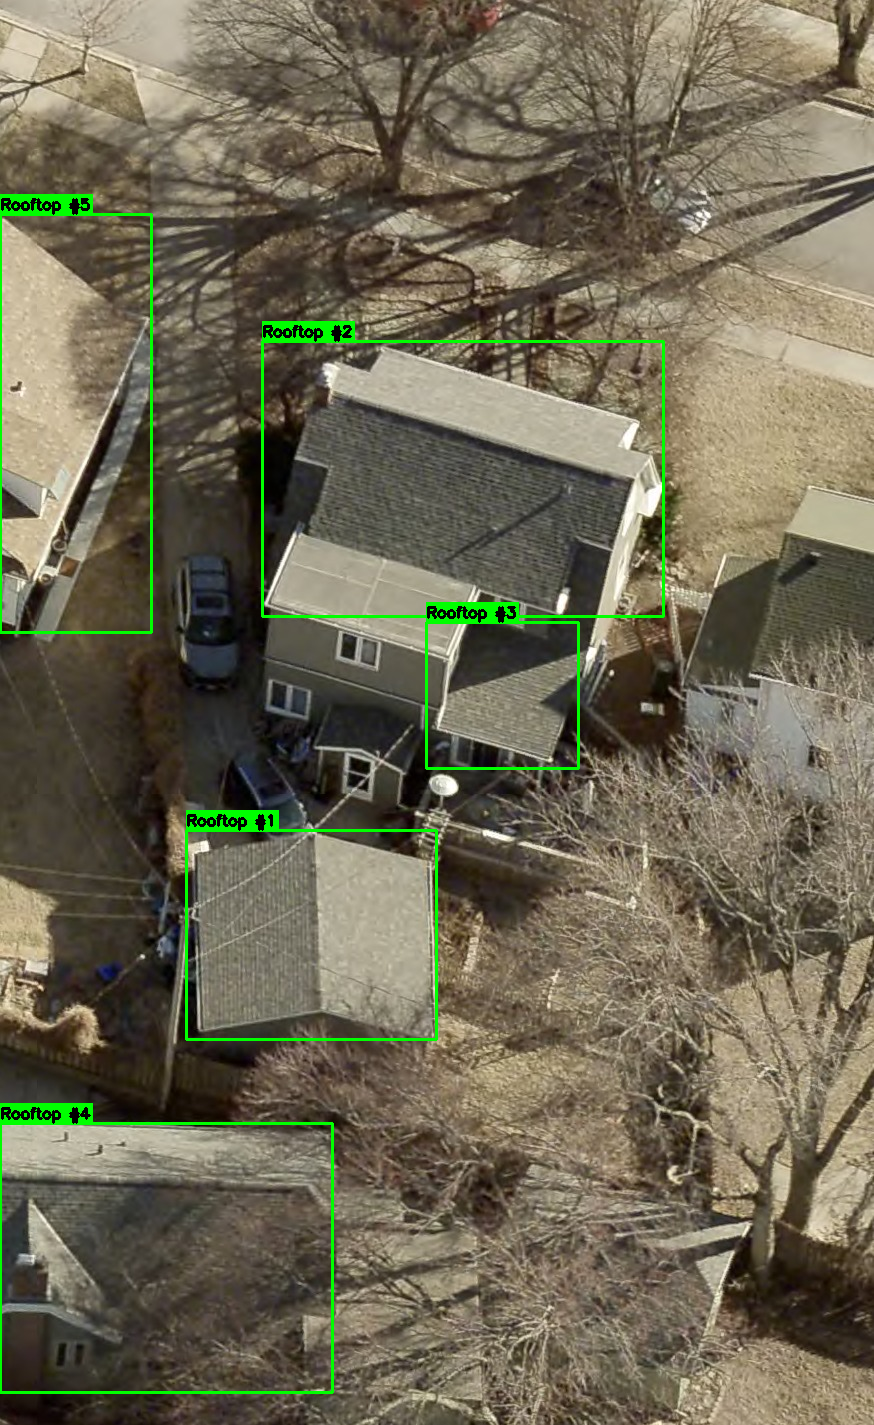

Saved to rooftop_annotated.jpg


In [ ]:
# @title 4. Visualization (Overlay Bounding Boxes)
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# 1. Convert PIL Image to OpenCV Format
# Moondream uses PIL (RGB), OpenCV uses BGR, so we convert it
open_cv_image = np.array(image)
open_cv_image = cv2.cvtColor(open_cv_image, cv2.COLOR_RGB2BGR)

# Get dimensions to calculate pixel coordinates
height, width, _ = open_cv_image.shape

print(f"Drawing {len(objects)} boxes on image size: {width}x{height}...")

# 2. Iterate and Draw
for i, obj in enumerate(objects):
    # Convert normalized (0-1) to pixels
    x1 = int(obj['x_min'] * width)
    y1 = int(obj['y_min'] * height)
    x2 = int(obj['x_max'] * width)
    y2 = int(obj['y_max'] * height)

    # Draw Rectangle (Green, thickness=2)
    cv2.rectangle(open_cv_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Add Label
    label_text = f"Rooftop #{i+1}"

    # Text background (for better visibility)
    (text_w, text_h), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
    cv2.rectangle(open_cv_image, (x1, y1 - 20), (x1 + text_w, y1), (0, 255, 0), -1)

    # Text
    cv2.putText(open_cv_image, label_text, (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

# 3. Display and Save
cv2_imshow(open_cv_image)
cv2.imwrite("rooftop_annotated.jpg", open_cv_image)
print("Saved to rooftop_annotated.jpg")

In [ ]:
# @title 1. Install Segment Anything (SAM)
import sys
print("Installed and downloaded weights.")

In [ ]:
!pip install -q segment-anything torchvision
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [ ]:
# # @title Fix: Re-download SAM Weights
# import os

# # 1. Delete the corrupted file
# if os.path.exists("sam_vit_h_4b8939.pth"):
#     print("Deleting corrupted file...")
#     os.remove("sam_vit_h_4b8939.pth")

# # 2. Download again (approx 2.4 GB)
# print("Downloading SAM weights (this may take 1-2 minutes)...")
# !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

# # 3. Verify file size (Should be ~2.5 GB)
# file_size = os.path.getsize("sam_vit_h_4b8939.pth") / (1024 * 1024)
# print(f"Download complete. File size: {file_size:.2f} MB")

# if file_size < 2000:
#     print("⚠️ WARNING: File looks too small. The download might have failed again.")
# else:
#     print("✅ File looks good. You can run the segmentation code below.")

Deleting corrupted file...
Download complete. File size: 2445.75 MB
✅ File looks good. You can run the segmentation code below.


In [ ]:
# @title 2. Generate "Hugging" Contours (Segmentation)
import torch
import cv2
import numpy as np
from segment_anything import sam_model_registry, SamPredictor
from google.colab.patches import cv2_imshow

# --- CONFIGURATION ---
# We use the 'Huge' model (vit_h) for best possible edge adherence
SAM_CHECKPOINT = "sam_vit_h_4b8939.pth"
MODEL_TYPE = "vit_h"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Initialize SAM
print(f"Loading SAM ({MODEL_TYPE})...")
sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_CHECKPOINT)
sam.to(device=DEVICE)
predictor = SamPredictor(sam)

# 2. Prepare Image
# SAM expects RGB (0-255)
image_rgb = np.array(image)
predictor.set_image(image_rgb)

# 3. Process Moondream Boxes
# Moondream gave us normalized (0-1) boxes: {'x_min': 0.2, ...}
# SAM needs absolute pixels: [x1, y1, x2, y2]
height, width = image_rgb.shape[:2]
input_boxes = []

for obj in objects:
    x1 = int(obj['x_min'] * width)
    y1 = int(obj['y_min'] * height)
    x2 = int(obj['x_max'] * width)
    y2 = int(obj['y_max'] * height)
    input_boxes.append([x1, y1, x2, y2])

input_boxes_tensor = torch.tensor(input_boxes, device=DEVICE)
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes_tensor, image_rgb.shape[:2])

# 4. Predict Masks
# We feed all boxes at once for speed
print(f"Segmenting {len(input_boxes)} rooftops...")
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

# 5. Draw the "Hugging Lines" (Contours)
output_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
overlay = output_image.copy()

# Iterate through the generated masks
for i, mask in enumerate(masks):
    # Mask is a boolean tensor, convert to numpy uint8
    mask_np = mask[0].cpu().numpy().astype(np.uint8)

    # A. Draw Filled Semi-Transparent Layer
    # Color: Green (0, 255, 0)
    color = (0, 255, 0)
    output_image[mask_np > 0] = color

    # B. Draw the "Hugging Line" (Contour)
    contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Thickness = 2, Color = White (for contrast)
    cv2.drawContours(overlay, contours, -1, (255, 255, 255), 2)

# Blend for transparency effect (0.6 original + 0.4 overlay)
final_image = cv2.addWeighted(overlay, 1.0, output_image, 0.4, 0)

# 6. Display
cv2_imshow(final_image)
cv2.imwrite("rooftop_segmented.jpg", final_image)
print("Saved result to 'rooftop_segmented.jpg'")

This cell output is too large and can only be displayed while logged in.
